## HW2 Severyn Balaniuk

### A
 
In short, dimensional reduction techniques such as PCA or t-SNE by defenition are classified as unsupervised learning methods because they do not require labeled data to work. When we used a FFNN to classify Ising phases, we utilized a labeled dataset - y_L30.txt, and the model learned by comparing its predictions to these labels. In contrast, for dimensionality reduction, we apply PCA and t-SNE to the dataset to group the data into two clusters. Unlike the FFNN approach, these clusters do not have predefined labels

In [14]:
import numpy as np
import pylab


def Hbeta(D=np.array([]), beta=1.0):
    """
    Compute the perplexity and the P-row for a specific value of the
    precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = max(sum(P), 1e-13)  # avoiding division by zero
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
    Performs a binary search to get P-values in such a way that each
    conditional Gaussian has the same perplexity.
    """
    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i + 1 : n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.0
                else:
                    beta[i] = (beta[i] + betamax) / 2.0
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.0
                else:
                    beta[i] = (beta[i] + betamin) / 2.0

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i + 1 : n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
    Runs PCA on the NxD array X in order to reduce its dimensionality to
    no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
    Runs t-SNE on the dataset in the NxD array X to reduce its
    dimensionality to no_dims dimensions. The syntaxis of the function is
    `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # checks if the data type of X is float and if no_dims is an integer.
    if not np.issubdtype(X.dtype, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.0  # early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2.0 * np.dot(Y, Y.T)
        num = 1.0 / (1.0 + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.0
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(
                np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0
            )

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.0) != (iY > 0.0)) + (gains * 0.8) * (
            (dY > 0.0) == (iY > 0.0)
        )
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.0

    # Return solution
    return Y

### B)

X: is the input data, which is an N x D  NumPy array where N is the number of data points and D is the number of dimensions

no_dims: the number of dimensions in the output. Typically, t-SNE reduces the data to 2 or 3 dimensions to allow for easy visualization

initial_dims: the number of dimensions to which the data should be reduced using PCA before applying t-SNE. This is an initial dimensionality reduction step to speed up the t-SNE algorithm

perplexity: is a hyperparameter that affects the balance between local and global aspects of the data. we can think about it as a measure of the effective number of nearest neighbors


Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.386597
Iteration 10: error is 23.640311
Iteration 20: error is 21.419285
Iteration 30: error is 17.949402
Iteration 40: error is 16.702788
Iteration 50: error is 16.399250
Iteration 60: error is 16.250816
Iteration 70: error is 16.114991
Iteration 80: error is 16.019731
Iteration 90: error is 15.954544
Iteration 100: error is 15.901274
Iteration 110: error is 2.291302
Iteration 120: error is 2.055169
Iteration 130: error is 1.878215
Iteration 140: error is 1.742867
Iteration 150: error is 1.638496
Iteration 160: error is 1.556577
Iteration 170: error is 1.490888
It

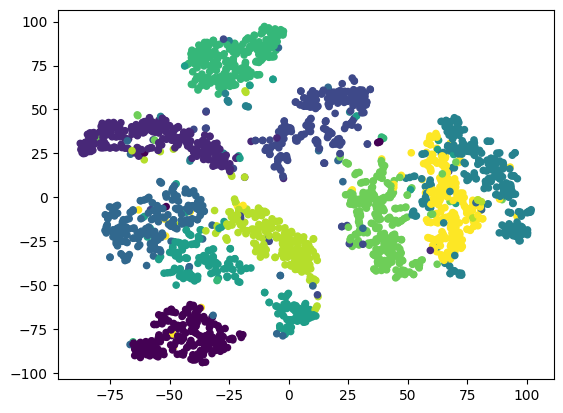

In [15]:
# How t-SNE works on MNIST dataset
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    X = np.loadtxt("tsne_python/mnist2500_X.txt")
    labels = np.loadtxt("tsne_python/mnist2500_labels.txt")
    Y = tsne(X, 2, 50, 20.0)
    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
    pylab.show()

### C)

In [16]:
# Loading spin configuration and temperature data, as well as spin configurations and labels for the gauge theory
# We have 3 different sizes: 20, 40, and 80

spins_ising_20 = np.loadtxt("spinConfigs_Ising_L20.txt")
spins_ising_40 = np.loadtxt("spinConfigs_Ising_L40.txt")
spins_ising_80 = np.loadtxt("spinConfigs_Ising_L80.txt")

temperatures_ising_20 = np.loadtxt("temperatures_Ising_L20.txt")
temperatures_ising_40 = np.loadtxt("temperatures_Ising_L40.txt")
temperatures_ising_80 = np.loadtxt("temperatures_Ising_L80.txt")

spins_gauge_20 = np.loadtxt("spinConfigs_gaugeTheory_L20.txt")
spins_gauge_40 = np.loadtxt("spinConfigs_gaugeTheory_L40.txt")
spins_gauge_80 = np.loadtxt("spinConfigs_gaugeTheory_L80.txt")

labels_gauge_20 = np.loadtxt("labels_gaugeTheory_L20.txt")
labels_gauge_40 = np.loadtxt("labels_gaugeTheory_L40.txt")
labels_gauge_80 = np.loadtxt("labels_gaugeTheory_L80.txt")

In [17]:
# Applying  t-SNE to size 20
# reducing the data to 2 dimensions, with 50 as the number of initial dimensions after PCA,
# and a perplexity = 20.0 to balance local and global aspects of the data.
spins_ising_20_tsne = tsne(spins_ising_20, 2, 50, 20.0)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 1.748357
Iteration 10: error is 20.195125
Iteration 20: error is 17.655952
Iteration 30: error is 17.072249
Iteration 40: error is 17.059329
Iteration 50: error is 17.042768
Iteration 60: error is 17.031981
Iteration 70: error is 17.030219
Iteration 80: error is 17.031834
Iteration 90: error is 17.033185
Iteration 100: error is 17.034216
Iteration 110: error is 2.729867
Iteration 120: error is 2.436319
Iteration 130: error is 2.197266
Iteration 140: error is 2.070544
Iteration 150: error is 1.986741
Iteration 160: error is 1.927099
Iteration 170: error is 1.878716
Iteration 180: error is 1.836284
Iteration 190: error is 1.800512
Iteration 200: error is 1.770409
Iteration 210: error is 1.744508
Iteration 220: error is 1.721489

In [18]:
#  running t-SNE on the gauge theory data for size 40 and then 80
spins_ising_40_tsne = tsne(spins_ising_40, 2, 50, 20.0)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 2.897560
Iteration 10: error is 21.331944
Iteration 20: error is 18.821338
Iteration 30: error is 17.561941
Iteration 40: error is 17.377987
Iteration 50: error is 17.304319
Iteration 60: error is 17.277044
Iteration 70: error is 17.247530
Iteration 80: error is 17.221091
Iteration 90: error is 17.199580
Iteration 100: error is 17.182441
Iteration 110: error is 2.591994
Iteration 120: error is 2.415201
Iteration 130: error is 2.304111
Iteration 140: error is 2.227083
Iteration 150: error is 2.164639
Iteration 160: error is 2.111655
Iteration 170: error is 2.066850
Iteration 180: error is 2.028421
Iteration 190: error is 1.996096
Iteration 200: error is 1.969446
Iteration 210: error is 1.946297
Iteration 220: error is 1.926076

In [19]:
spins_ising_80_tsne = tsne(spins_ising_80, 2, 50, 20.0)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 4.548898
Iteration 10: error is 20.830102
Iteration 20: error is 17.613690
Iteration 30: error is 16.535048
Iteration 40: error is 16.422978
Iteration 50: error is 16.352460
Iteration 60: error is 16.314627
Iteration 70: error is 16.303584
Iteration 80: error is 16.281236
Iteration 90: error is 16.261330
Iteration 100: error is 16.245016
Iteration 110: error is 2.385994
Iteration 120: error is 2.223250
Iteration 130: error is 2.153485
Iteration 140: error is 2.106733
Iteration 150: error is 2.068531
Iteration 160: error is 2.036135
Iteration 170: error is 2.007362
Iteration 180: error is 1.982686
Iteration 190: error is 1.961422
Iteration 200: error is 1.942887
Iteration 210: error is 1.926951
Iteration 220: error is 1.913148

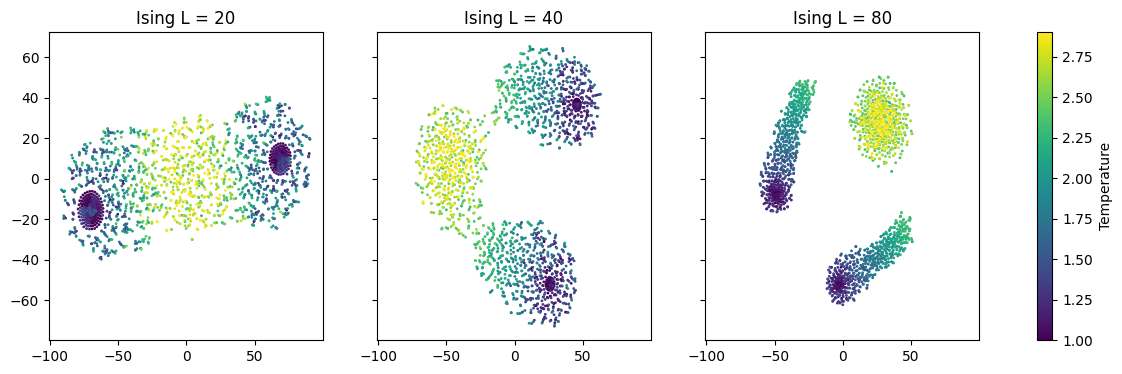

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and three subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

# Plot the scatter plots on each subplot
scatter0 = axs[0].scatter(
    spins_ising_20_tsne[:, 0], spins_ising_20_tsne[:, 1], c=temperatures_ising_20, s=1
)
axs[0].set_title("Ising L = 20")

scatter1 = axs[1].scatter(
    spins_ising_40_tsne[:, 0], spins_ising_40_tsne[:, 1], c=temperatures_ising_40, s=1
)
axs[1].set_title("Ising L = 40")

scatter2 = axs[2].scatter(
    spins_ising_80_tsne[:, 0], spins_ising_80_tsne[:, 1], c=temperatures_ising_80, s=1
)
axs[2].set_title("Ising L = 80")

# Add a colorbar on the right side of the last subplot
cbar = fig.colorbar(
    scatter2, ax=axs.ravel().tolist(), orientation="vertical", label="Temperature"
)

# Show the plot
plt.show()

### D)
We can observe that clustering gets better with size of the lattice. It could be explained by the fact that as the lattice size increases, the system more accurately reflects the differecne between two states: paramagnetic or ferromagnetic.

If we run t-SNE on the Ising_80 dataset a second time, the result may differ due to the inherent stochastic nature of t-SNE, which can lead to variations in the clustering of unlabeled data. Lest test it: 

In [21]:
spins_ising_80_tsne_run2 = tsne(spins_ising_80, 2, 50, 20.0)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 4.548898
Iteration 10: error is 21.150839
Iteration 20: error is 17.572902
Iteration 30: error is 16.597545
Iteration 40: error is 16.436268
Iteration 50: error is 16.366477
Iteration 60: error is 16.335090
Iteration 70: error is 16.318510
Iteration 80: error is 16.297338
Iteration 90: error is 16.277514
Iteration 100: error is 16.270616
Iteration 110: error is 2.383680
Iteration 120: error is 2.220002
Iteration 130: error is 2.154767
Iteration 140: error is 2.109178
Iteration 150: error is 2.070871
Iteration 160: error is 2.037757
Iteration 170: error is 2.008774
Iteration 180: error is 1.984037
Iteration 190: error is 1.963025
Iteration 200: error is 1.944823
Iteration 210: error is 1.928544
Iteration 220: error is 1.914164

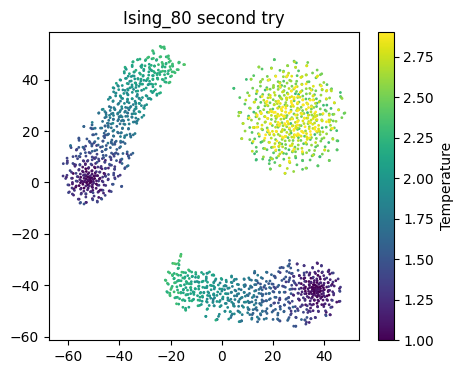

In [22]:
fig, ax = plt.subplots(1, figsize=(5, 4))

# Plot the scatter plot on the subplot
scatter = ax.scatter(
    spins_ising_80_tsne_run2[:, 0],
    spins_ising_80_tsne_run2[:, 1],
    c=temperatures_ising_80,
    s=1,
)
ax.set_title("Ising_80 second try")

# Add a colorbar on the right side of the plot
fig.colorbar(scatter, ax=ax, orientation="vertical", label="Temperature")

# Show the plot
plt.show()

Discussion:
- We can see that our second run of the same Ising model gives us a slightly different plot. The lowest temperatures are located in different places than originally. Additionally, the size and coordinates of the clusters are different. As we discussed earlier, this could be explained by the non-convex t-SNE loss function, which has many peaks and valleys. Depending on the random starting positions, the gradient descent can end up in different valleys, leading to different results.

- Our results are similar to Fig. 6 from the paper in Ref[3]. We can clearly see three distinct clusters.

- Well, it could be generally summorized in 4 key points why we observe different results:

    * Approach: PCA uses linear transformations, while t-SNE uses non-linear transformations.
    * Interpretation: PCA maintains the physical significance of dimensions, while t-SNE does not.
    * Clustering: t-SNE provides clearer separation of clusters compared to PCA.
    * Consistency: PCA results are consistent, while t-SNE results can vary due to its stochastic nature.
    
Specifically, this means that the way PCA and t-SNE operate is quite different. PCA takes an L2-dimensional space, looks for the 'most important' directions, and when plotted on the first two principal components, it can reveal distinct nodes. Importantly for us, it can show good separation between FM and PM phases. On the other hand, t-SNE uses PCA initially to reduce dimensionality and then further reduces dimensions without assuming important dimensions. The final axes may not have physical meaning, but they provide clearer separation.

### E)

In [23]:
# Applying t-SNE to the spin configurations of the gauge theory with a lattice size of 20.
spins_gauge_20_tsne = tsne(spins_gauge_20, 2, 50, 20.0)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 3.428661
Iteration 10: error is 20.825736
Iteration 20: error is 20.895132
Iteration 30: error is 20.360634
Iteration 40: error is 20.533862
Iteration 50: error is 21.330815
Iteration 60: error is 21.216335
Iteration 70: error is 20.971466
Iteration 80: error is 20.990089
Iteration 90: error is 21.293592
Iteration 100: error is 21.321363
Iteration 110: error is 3.728857
Iteration 120: error is 3.295953
Iteration 130: error is 3.116056
Iteration 140: error is 2.984092
Iteration 150: error is 2.911961
Iteration 160: error is 2.864412
Iteration 170: error is 2.828509
Iteration 180: error is 2.798499
Iteration 190: error is 2.773279
Iteration 200: error is 2.751526
Iteration 210: error is 2.732513
Iteration 220: error is 2.716166
Iteration 230: error is 2.702575
Iteration 240: error is 2.691239
Iteration 250: error is

In [24]:
# and same for gauge theory with lattice size 40
spins_gauge_40_tsne = tsne(spins_gauge_40, 2, 50, 20.0)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 5.169702
Iteration 10: error is 20.461829
Iteration 20: error is 20.314736
Iteration 30: error is 20.714650
Iteration 40: error is 21.164452
Iteration 50: error is 21.254024
Iteration 60: error is 21.162847
Iteration 70: error is 21.526849
Iteration 80: error is 21.085053
Iteration 90: error is 21.258808
Iteration 100: error is 21.511247
Iteration 110: error is 3.845708
Iteration 120: error is 3.452926
Iteration 130: error is 3.241515
Iteration 140: error is 3.081920
Iteration 150: error is 2.937141
Iteration 160: error is 2.824901
Iteration 170: error is 2.798901
Iteration 180: error is 2.770714
Iteration 190: error is 2.752057
Iteration 200: error is 2.734897
Iteration 210: error is 2.719481
Iteration 220: error is 2.704881
Iteration 230: error is 2.692778
Iteration 240: error is 2.683084
Iteration 250: error is

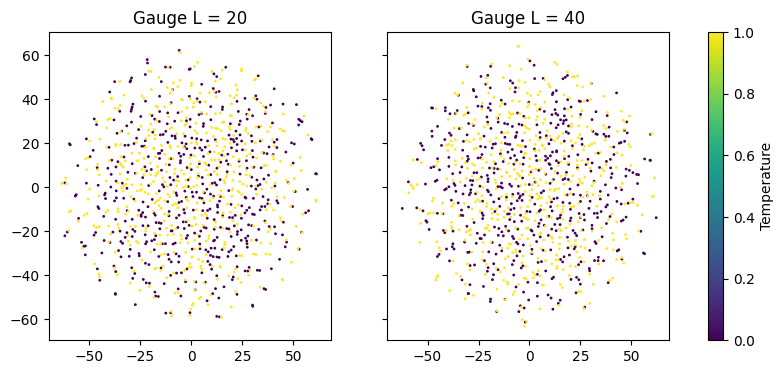

In [25]:
# Create a figure and two subplots arranged horizontally
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Plot the scatter plot for Gauge L = 20
scatter0 = axs[0].scatter(
    spins_gauge_20_tsne[:, 0], spins_gauge_20_tsne[:, 1], c=labels_gauge_20, s=1
)
axs[0].set_title("Gauge L = 20")

# Plot the scatter plot for Gauge L = 40
scatter1 = axs[1].scatter(
    spins_gauge_40_tsne[:, 0], spins_gauge_40_tsne[:, 1], c=labels_gauge_40, s=1
)
axs[1].set_title("Gauge L = 40")

# Add a colorbar on the right side of the plot
fig.colorbar(
    scatter1, ax=axs.ravel().tolist(), orientation="vertical", label="Temperature"
)

# Show the plot
plt.show()

### F)

As I understand it, t-SNE fails to produce distinct clusters when applied to classical Ising gauge theory data because the method relies heavily on Euclidean distances to define similarities between data points. t-SNE preserves local structures by prioritizing short-distance information in the lower-dimensional space.

In the context of classical Ising gauge theory, the issue arises from the nature of topological order. Two configurations that are topologically equivalent can differ significantly in their Euclidean distance. For example, configurations that differ by a Wilson loop can still belong to the same topological phase, even though their Euclidean distance is large due to differences in the number of spins on the order of the lattice size 𝐿.

In contrast, in the regular Ising model, the order parameter, meaning magnetization, correlates well with the Euclidean distance between configurations. This correlation allows t-SNE to cluster different phases more effectively because changes in the magnetization reflect the physical distances between configurations.


